### **Spectral Clustering**

As illustrated with HDBScan above, data can be represented as a graph, where:

- **Nodes**: Represent individual data points.
- **Edges**: Connect pairs of data points. The weight of an edge typically reflects the similarity between two nodes.

To capture the pairwise similarities between data points, we construct an **Affinity Matrix**. Common methods to define similarity include:

- Gaussian kernel of the Euclidean distance (i.e. standard deviation based on local data)
- Nearest neighbors.

The goal of graph-based clustering methods is to partition the graph such that:
- Edges between different groups have low weights (indicating dissimilarity).
- Edges within a group have high weights (indicating similarity).


#### Graph Laplacian and its Eigenvalues**

The **Laplacian Matrix** of a graph captures information about the degree of each vertex and the edges of the graph. It is defined as:
$ L = D - W $
Where:
-$ L $ is the Laplacian matrix.
- $ D $ is the diagonal degree matrix.
- $ W $ is the affinity matrix.

The eigenvalues and eigenvectors of the Laplacian matrix play a pivotal role in spectral clustering. For a graph with $ n $ connected components, the smallest $ n $ eigenvalues of its Laplacian are zero.

The eigenvector corresponding to the second smallest eigenvalue (Fiedler vector) is used for bipartitioning the graph. The sign of its components can determine the two clusters. For more clusters, the data is embedded using the first $ k $ eigenvectors, and then k-means can be applied in this space.

***Why the Laplacian?***

The Laplacian is a mathematical representation of a graph that helps to make the clustering structure more apparent.  For instance, consider the following example:


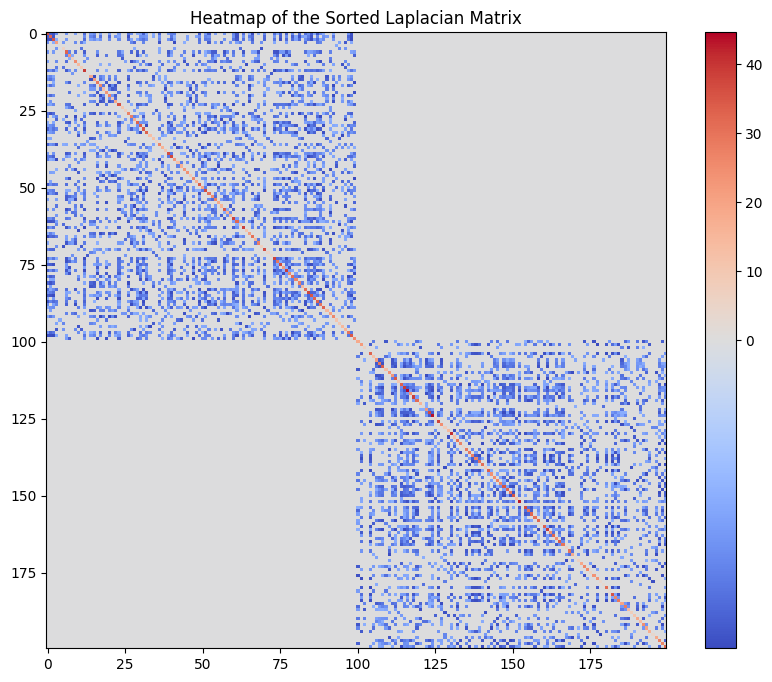

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
from scipy.sparse.csgraph import laplacian
import matplotlib.colors as mcolors

# 1. Generate synthetic data with two distinct blobs
X, y = make_blobs(n_samples=200, centers=2, cluster_std=1.0, random_state=42)

# 2. Construct the affinity (or adjacency) matrix using RBF kernel
sigma = 1.0
distances = pairwise_distances(X, squared=True)
affinity_matrix = np.exp(-distances / (2.0 * sigma**2))
threshold = 0.5
affinity_matrix[affinity_matrix < threshold] = 0

# 3. Compute the Laplacian matrix
L = laplacian(affinity_matrix, normed=False)

# 4. Sort the Laplacian matrix based on cluster assignments
sorted_idx = np.argsort(y)
L_sorted = L[sorted_idx, :]
L_sorted = L_sorted[:, sorted_idx]

# 5. Create a custom colormap normalization to emphasize smaller negative values
norm = mcolors.TwoSlopeNorm(vmin=L_sorted.min(), vmax=L_sorted.max(), vcenter=0)

# 6. Visualize the sorted Laplacian matrix with the custom normalization
plt.figure(figsize=(10, 8))
plt.imshow(L_sorted, cmap='coolwarm', aspect='auto', norm=norm)
plt.colorbar()
plt.title("Heatmap of the Sorted Laplacian Matrix")
plt.show()





#### How Spectral Clustering Identifies Non-convex Clusters

Spectral clustering's strength lies in its ability to detect non-convex clusters. This non-linear clustering capability is derived from its use of the graph structure and eigenvalues of the Laplacian.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


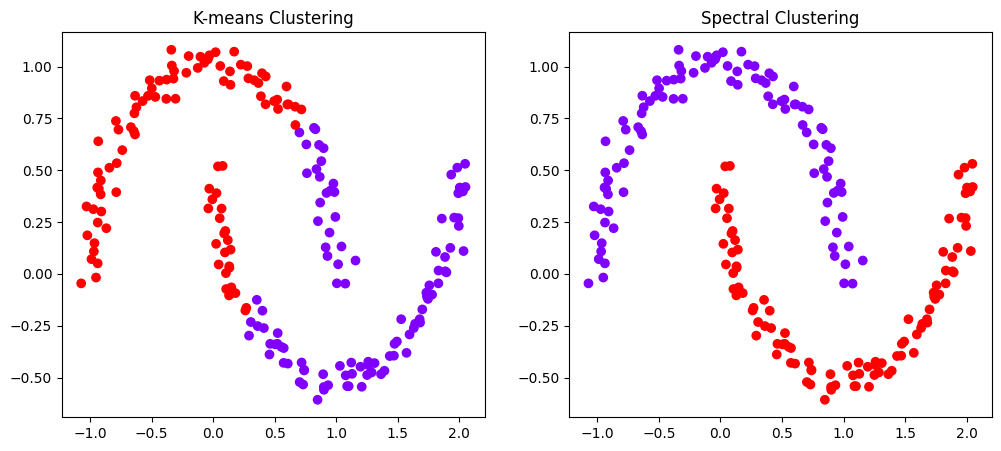

In [2]:
from sklearn.datasets import make_moons
from sklearn.cluster import SpectralClustering, KMeans
import matplotlib.pyplot as plt

data, labels = make_moons(n_samples=200, noise=0.05)
spectral_labels = SpectralClustering(n_clusters=2, affinity='nearest_neighbors').fit_predict(data)
kmeans_labels = KMeans(n_clusters=2).fit_predict(data)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(data[:, 0], data[:, 1], c=kmeans_labels, cmap='rainbow')
ax1.set_title('K-means Clustering')
ax2.scatter(data[:, 0], data[:, 1], c=spectral_labels, cmap='rainbow')
ax2.set_title('Spectral Clustering')
plt.show()

#### Key Parameters

1. **Number of Clusters (`n_clusters`)**:
   - This parameter specifies how many clusters the algorithm should partition the data into. It's akin to the "k" in k-means clustering.
   
2. **Affinity (`affinity`)**:
   - This defines the method used to compute the affinity matrix, which captures the pairwise similarity between points. Common choices include:
     - **'nearest_neighbors'**: Compute the affinity matrix based on the number of nearest neighbors. This often results in a graph with local neighborhood structures.
     - **'rbf'**: Uses the radial basis function (RBF or Gaussian) kernel to compute similarities. It has the form $\exp(-\gamma \times d^2) $, where $d$ is the distance between data points.
     - **'precomputed'**: If you have a precomputed affinity matrix, you can use it directly.
     - **'linear'**, **'poly'**, **'sigmoid'**, etc.: Other kernel-based similarity measures.
   - The choice of affinity can significantly impact clustering results. For instance, 'nearest_neighbors' can be useful for capturing local cluster structures, while 'rbf' may be more suitable for globular clusters.

3. **Gamma (`gamma`)**:
   - It's a parameter for the RBF, poly, sigmoid, and other kernel-based affinity measures. It determines the influence or spread of a single training example. For the RBF kernel, a smaller value of `gamma` will produce a wider spread (so points farther apart are considered similar), while a larger value will make it consider only points close to each other.

4. **Number of Neighbors (`n_neighbors`)**:
   - Relevant when `affinity` is set to 'nearest_neighbors'. It specifies how many neighbors are considered for each point when constructing the affinity matrix.

5. **Degree (`degree`)**:
   - Only used when the affinity is 'poly'. It's the degree of the polynomial kernel function.

6. **Coefficient (`coef0`)**:
   - Used in 'poly' and 'sigmoid' affinity settings. It represents an independent term in the kernel function.

Each of these parameters can influence the performance and outcome of spectral clustering. It's often beneficial to experiment with different combinations, especially for the affinity and gamma parameters, to find the most appropriate settings for a given dataset.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import SpectralClustering
import hdbscan

# Create synthetic data: two moons + noise + a dense small cluster
moons_data, _ = make_moons(n_samples=150, noise=0.05)
noise = np.random.rand(50, 2) * 2.5 - 1.25
dense_cluster = np.random.rand(50, 2) * 0.2 + [1, -0.25]
data = np.vstack([moons_data, noise, dense_cluster])

# DBScan clustering
spectral_labels = SpectralClustering(n_clusters=3, affinity='nearest_neighbors').fit_predict(data)

# HDBScan clustering
hdbscan_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=10).fit_predict(data)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(data[:, 0], data[:, 1], c=spectral_labels, cmap='rainbow', s=50)
ax1.set_title('Spectral Clustering')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

ax2.scatter(data[:, 0], data[:, 1], c=hdbscan_labels, cmap='rainbow', s=50)
ax2.set_title('HDBScan Clustering')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'hdbscan'



**Applications**:

- **Image Segmentation**: Grouping regions with similar pixel values or textures.
- **Social Network Analysis**: Identify tight-knit communities within larger networks.
- **Dimensionality Reduction**: Preserve the non-linear structure of the data.

**Pros**:
- Ability to detect non-convex clusters.
- Versatility across various domains.

**Cons**:
- Computationally expensive for large datasets.
- The choice of affinity matrix can influence results.


#### Spectral Clustering vs HDBScan:

- **Spectral Clustering** is particularly useful when the data has a clear non-linear structure or when the data can be naturally represented as a graph. It's also beneficial when the number of clusters is known or can be estimated.  Particularly well suited to data from social networks because of it's underlying graph-theoretic basis.

- **HDBScan** shines in scenarios where clusters are of varying densities, and there's potential noise in the data. It's also useful when the number of clusters is unknown or when a hierarchical understanding of clusters is desired. It also handles noise, but is highly sensitive to hyperparameters.